# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [ ]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [ ]:
#!pip install -qU qdrant-client

In [3]:
#!pip install ragas==0.0.19

In [4]:
#!pip install llama-index==0.8.35

We'll also provide our OpenAI key, as well as our Cohere API key.

In [5]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [6]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [7]:
#!pip install urllib

In [8]:
## Task 1: Getting Dependencies!
import urllib.request
urls = [
    ('https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv', 'john_wick_1.csv'),
    ('https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv', 'john_wick_2.csv'),
    ('https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv', 'john_wick_3.csv'),
    ('https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv', 'john_wick_4.csv')
]

for url, filename in urls:
    urllib.request.urlretrieve(url, filename)

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [9]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta
import urllib.request

# First download and fix the encoding of the files
urls = [
    ('https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv', 'john_wick_1.csv'),
    ('https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv', 'john_wick_2.csv'),
    ('https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv', 'john_wick_3.csv'),
    ('https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv', 'john_wick_4.csv')
]

for url, filename in urls:
    # Download the file
    urllib.request.urlretrieve(url, filename)
    
    # Read and rewrite the file with UTF-8 encoding
    with open(filename, 'r', encoding='latin-1') as source:
        content = source.read()
    with open(filename, 'w', encoding='utf-8') as target:
        target.write(content)

# Now load the documents with the fixed encoding
documents = []

for i in range(1, 5):
    loader = CSVLoader(
        file_path=f"john_wick_{i}.csv",
        metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"],
        encoding="utf-8"  # Explicitly set encoding to UTF-8
    )

    movie_docs = loader.load()
    for doc in movie_docs:
        # Add the "Movie Title" (John Wick 1, 2, ...)
        doc.metadata["Movie_Title"] = f"John Wick {i}"

        # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
        doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

        # newer movies have a more recent "last_accessed_at"
        doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

    documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [10]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\r\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 5, 16, 2, 26, 40, 500621)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [11]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [12]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [13]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [14]:
#!pip install langchain-openai

In [15]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model_name="gpt-4.1-nano")


### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [16]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [17]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided in the context, people generally liked John Wick. Several reviews gave high ratings (e.g., 9 or 10 out of 10) and described the film as stylish, fun, and a standout action movie. Many reviewers praised its action sequences, choreography, and overall entertainment value. While some critics expressed mixed or lower opinions, the overall sentiment indicates that the film was well-received and appreciated by most viewers.'

In [18]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [19]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick film series, the story revolves around John Wick, a retired hitman who seeks vengeance after a series of personal tragedies. The first film starts with Wick mourning the death of his wife and the killing of his beloved dog by gangsters who steal his car. Enraged and driven by revenge, Wick unleashes a brutal and carefully orchestrated revenge against those who wronged him, becoming a target for bounty hunters and assassins because of a price on his head.\n\nSubsequent films continue to explore Wick's life as an assassin caught in a world of criminal organizations and rules, with stories involving old debts, conflicts with the Russian mafia, and battles with other professional killers. Each movie features intense action sequences, stylish combat, and complex world-building centered around the code of the assassin community.\n\nOverall, the series depicts Wick's relentless pursuit of retribution and survival amid deadly conflicts, showcasing a dark underworld filled wit

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [20]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [21]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [22]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, opinions on people generally liking John Wick are mixed. While some reviewers highlight the film's stylish action, smooth sequences, and overall entertainment value, others criticize it for being repetitive, lacking plot, and full of violence. Therefore, it appears that some people liked John Wick, especially fans of action movies, but there are also negative opinions."

In [23]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'No, there are no reviews with a rating of 10 in the provided data.'

In [24]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick film series, the story centers around John Wick, a former hitman who comes out of retirement to seek vengeance. The original movie depicts how Wick's peaceful life is disrupted when gangsters steal his car and kill his dog, a gift from his deceased wife. This act triggers Wick's return to his violent past as he searches for those responsible, leading to a series of intense and well-choreographed action scenes. The series explores his interactions with an underground world of assassins and crime lords, highlighting themes of revenge, redemption, and the consequences of violence."

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [25]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [26]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [27]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people generally liked John Wick. The first two reviews are highly positive, praising the film's action sequences, performances, and overall entertainment value, with ratings of 9 and 10. The third review, however, is negative about the third installment, giving it a rating of 5 and expressing disappointment. Overall, the majority of the reviews suggest that people appreciated the movie, especially the first film, indicating that most people generally liked John Wick."

In [28]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. Here are the URLs to those reviews:\n\n1. [Review of John Wick 3 titled "A Masterpiece & Brilliant Sequel"]( /review/rw4854296/?ref_=tt_urv )\n2. [Review mentioning the franchise\'s quality and comparison to Marvel]( /review/rw4860412/?ref_=tt_urv )'

In [29]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, John Wick, a retired hitman, returns to the violent underworld to seek vengeance after his house is bombed and his beloved dog is killed. The story begins when a mobster named Santino D'Antonio shows Wick a marker, a symbol of a blood oath, and asks for his help in killing his sister to secure a seat on the High Table of criminal organizations. Wick initially refuses but is later compelled to accept after Santino threatens him, leading Wick to travel to Rome to carry out the murder. After completing the task, Santino betrays Wick and puts a contract on his life, making him a target for professional killers. The films depict Wick's relentless pursuit of revenge and survival against these deadly adversaries, highlighting his skills, code of honor, and the dark criminal world he inhabits."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [30]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [31]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [32]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews in the provided context, people generally liked John Wick. Many reviews are highly positive, praising its action sequences, style, and entertainment value. For example, some reviewers gave ratings of 9 or 10 out of 10 and described the film as a "wild ride," "slick," "brilliantly shot," and "fun." However, there are some mixed and negative opinions as well, with a few giving lower ratings and expressing confusion or disappointment. Overall, the dominant sentiment in the reviews suggests that people generally liked John Wick.'

In [33]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. The URLs to those reviews are:\n\n1. /review/rw4854296/?ref_=tt_urv\n2. /review/rw8944843/?ref_=tt_urv'

In [34]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick series, the story revolves around John Wick, a retired assassin who is pulled back into a violent underworld of crime and action. The series begins with Wick seeking vengeance after a gangsters kill his dog and steal his car. As the series progresses, Wick becomes entangled in complex criminal dealings, including helping to take over the Assassin's Guild, fighting against various enemies, and dealing with an expansive criminal universe with strict rules and a high-stakes underworld. Throughout the films, John Wick is depicted as a highly skilled and formidable hitman navigating a world filled with assassins, powerful mobsters, and dangerous alliances, all while seeking retribution and survival. The franchise is characterized by high-octane action sequences, stylized violence, and a richly developed underground world."

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [35]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [36]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

C:\Users\T\AppData\Local\Temp\ipykernel_30204\3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [37]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [38]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [39]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [40]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the provided reviews, people\'s opinions about John Wick are mixed. Some reviews are highly positive, praising the action and overall series, while at least one review expresses a very negative opinion, calling the latest movie "HORRIBLE" and criticizing its plot and fight scenes. Therefore, people did not generally have a single uniform opinion; there are both fans who love the series and some who dislike the recent installment.'

In [41]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review that has a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv.'

In [42]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, John Wick is a retired assassin who comes out of retirement due to personal reasons and circumstances involving violence and revenge. The first film depicts how he seeks vengeance after his dog is killed and his car is stolen, leading him to take down numerous gangsters and assassins. The second film continues the story, where he is called back into action to help with an old debt, which involves dangerous travels across Italy, Canada, and Manhattan, and results in lots of action and combat against other assassins. Overall, the series is known for its intense violence, action, and the character's quest for retribution."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [43]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [44]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [45]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people generally liked John Wick. Many reviews rate it highly, praising its action sequences, style, and entertainment value. For example, some reviews give it ratings of 9 or 10 out of 10 and describe it as "slick," "brilliant," and "must-see" for action fans. However, there are some negative opinions as well, with a few critics giving it low ratings and describing it as overly violent, lacking plot, or implausible. Overall, the sentiment leans toward a positive reception with most viewers appreciating it, especially fans of action films.'

In [46]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. Here are the URLs to those reviews:\n\n1. Review Title: "A Masterpiece & Brilliant Sequel"  \n   URL: /review/rw4854296/?ref_=tt_urv\n\n2. Review Title: "Most American action flicks released these days have poor screenplays and overuse computer-generated imagery..." (positive recognition of the franchise)  \n   URL: /review/rw9033669/?ref_=tt_urv'

In [47]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, the story revolves around a retired hitman named John Wick, played by Keanu Reeves, who seeks revenge after suffering personal losses and facing threats from the criminal underworld. The original film shows Wick coming out of retirement to avenge the death of his dog and the theft of his car, unleashing a brutal and meticulously choreographed trail of destruction against those who cross him. The subsequent films expand on this world, depicting Wick's ongoing battles with assassins, mobsters, and enforceable rules within the assassin community, all while exploring themes of vengeance, consequence, and the code of honor among killers. Overall, John Wick's story is a combination of personal revenge and survival in a dark, stylish underworld of crime."

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [48]:
!pip install -qU langchain_experimental


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [49]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [50]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [51]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [52]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [53]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [54]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the provided reviews and context, people generally liked John Wick. Multiple reviews are highly positive, praising its action, style, and entertainment value, indicating that the franchise has been well-received by many viewers.'

In [55]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is:  \n[https://yourdomain.com/review/rw4854296/?ref_=tt_urv](https://yourdomain.com/review/rw4854296/?ref_=tt_urv)'

In [56]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"Based on the provided context, in John Wick, the story revolves around a retired assassin named John Wick (played by Keanu Reeves) who seeks revenge after a group of thugs break into his house, beat him up, steal his car, and kill his beloved dog. The dog was significant to him, symbolizing his last connection to his wife who had recently passed away. The attack triggers Wick's return to his former life of violence as he unleashes a relentless, orchestrated vendetta against those responsible, including the Russian mobsters involved. The film features intense action, stylish stunts, and a narrative centered on revenge and consequences."

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [57]:
import pandas as pd

# Load all reviews from john_wick_1–4.csv
dfs = [pd.read_csv(f"john_wick_{i}.csv", header=None) for i in range(1, 5)]
combined_df = pd.concat(dfs, ignore_index=True)

# Use column 5 (index = 5) as review text
combined_df = combined_df[[5]]
combined_df.columns = ["doc"]

# Filter out short rows
combined_df = combined_df.dropna()
combined_df = combined_df[combined_df["doc"].str.len() > 50]

# Save as golden_balanced_john_wick.csv
combined_df.to_csv("golden_balanced_john_wick.csv", index=False)


Evaluate

In [59]:
#!pip install matplotlib

In [73]:
from langchain_openai import ChatOpenAI
import uuid, json, textwrap, pandas as pd
from langchain.schema import Document
from tqdm import tqdm

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.3)

# Categories and how many you want per category
types = {
    "factual": 30,
    "reasoning": 30,
    "multi-hop": 30,
    "hard_negative": 30,
}

PROMPTS = {
    "factual": textwrap.dedent("""
        Given the following movie review delimited by triple backticks:

        ```{review}```

        Write ONE concise factual question (what, who, when) that can be answered using only this review. 
        Return a JSON with keys "question" and "answer" (the exact answer from the text).
    """),
    "reasoning": textwrap.dedent("""
        Given the following movie review delimited by triple backticks:

        ```{review}```

        Write ONE question that requires reasoning (why or how) to answer, using only this review.
        Return a JSON with keys "question" and "answer" (verbatim from the review).
    """),
    "multi-hop": textwrap.dedent("""
        Given the following movie review delimited by triple backticks:

        ```{review}```

        Write ONE question that requires combining multiple facts from the review to answer (multi-hop).
        Return a JSON with keys "question" and "answer".
    """),
    "hard_negative": textwrap.dedent("""
        Given the following movie review delimited by triple backticks:

        ```{review}```

        Write ONE tricky question that includes a distractor — but can still be answered correctly from this review.
        Return a JSON with keys "question" and "answer".
    """),
}

qa_rows = []
used_docs = set()

# Repeat until all categories are filled
for qa_type, target in types.items():
    print(f"\n⚙️ Generating: {qa_type}")
    count = 0
    for i, doc in enumerate(tqdm(docs, desc=qa_type)):
        if count >= target:
            break
        content = doc.page_content.strip()[:1200]
        prompt = PROMPTS[qa_type].format(review=content)
        try:
            resp = llm.invoke(prompt).content
            qa = json.loads(resp)
            qa_rows.append({
                "id": str(uuid.uuid4())[:8],
                "question": qa["question"],
                "ground_truth_context": qa["answer"],
                "question_type": qa_type
            })
            count += 1
        except Exception as e:
            continue  # skip bad response



⚙️ Generating: factual


factual:  30%|███       | 30/100 [00:18<00:42,  1.63it/s]



⚙️ Generating: reasoning


reasoning:  30%|███       | 30/100 [00:22<00:53,  1.32it/s]



⚙️ Generating: multi-hop


multi-hop:  30%|███       | 30/100 [00:25<00:59,  1.17it/s]



⚙️ Generating: hard_negative


hard_negative:  30%|███       | 30/100 [00:17<00:41,  1.69it/s]


In [74]:
golden_df = pd.DataFrame(qa_rows)
golden_df.to_csv("golden_johnwick_by_type.csv", index=False)
print(f"✅ Saved {len(golden_df)} QA pairs → golden_johnwick_by_type.csv")


✅ Saved 120 QA pairs → golden_johnwick_by_type.csv


In [75]:
retrievers = {
    "Naive": naive_retriever,
    "BM25": bm25_retriever,
    "MultiQuery": multi_query_retriever,
    "ContextualCompression": compression_retriever,
    "Semantic": semantic_retriever,
    "Ensemble": ensemble_retriever,
    "ParentDoc": parent_document_retriever
}

In [76]:
import time
import pandas as pd
from difflib import SequenceMatcher
from tqdm import tqdm
from langchain.schema import Document

# === Parameters ===
SAMPLE_SIZE = min(30, len(golden_df))
eval_df = golden_df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)


# === Eval Subset ===
eval_df = golden_df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)

# === Fuzzy Match Function ===
def fuzzy_match(a, b, threshold=0.85):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio() >= threshold

# === Retriever Evaluator ===
def evaluate_retriever(df: pd.DataFrame, retriever, name="unnamed", k=10):
    from tqdm import tqdm
    import time

    hits, ranks = 0, []
    t0 = time.time()

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Evaluating {name}"):
        q = row["question"]
        truth = str(row["ground_truth_context"]).strip().lower()

        try:
            docs = retriever.get_relevant_documents(q)
            content = [getattr(d, "page_content", "").lower() for d in docs[:k]]
            rank = next(i for i, c in enumerate(content, 1) if truth in c)
            hits += 1
            ranks.append(rank)
        except StopIteration:
            continue
        except Exception as e:
            tqdm.write(f"⚠️ {name} error: {e}")
            continue

    n = len(df)
    precision = hits / (n * k) if n else 0
    recall = hits / n if n else 0
    mrr = sum(1 / r for r in ranks) / n if ranks else 0
    elapsed = time.time() - t0

    return {
        "Retriever": name,
        "Precision@10": round(precision, 3),
        "Recall@10": round(recall, 3),
        "MRR": round(mrr, 3),
        "Latency (s)": round(elapsed, 1),
    }


# === Run ===
rows = []
for name, retr in retrievers.items():
    print(f"\n🔍 Evaluating {name} …")
    result = evaluate_retriever(eval_df, retr, name)
    rows.append(result)

results_df = pd.DataFrame(rows).sort_values("MRR", ascending=False)
display(results_df)

results_df = pd.DataFrame(rows).sort_values("MRR", ascending=False)
print("\n📊 Evaluation Results:")
display(results_df)



🔍 Evaluating Naive …


Evaluating Naive: 100%|██████████| 30/30 [00:05<00:00,  5.11it/s]



🔍 Evaluating BM25 …


Evaluating BM25: 100%|██████████| 30/30 [00:00<00:00, 2186.81it/s]



🔍 Evaluating MultiQuery …


Evaluating MultiQuery: 100%|██████████| 30/30 [00:48<00:00,  1.62s/it]



🔍 Evaluating ContextualCompression …


Evaluating ContextualCompression: 100%|██████████| 30/30 [00:08<00:00,  3.42it/s]



🔍 Evaluating Semantic …


Evaluating Semantic: 100%|██████████| 30/30 [00:06<00:00,  4.66it/s]



🔍 Evaluating Ensemble …


Evaluating Ensemble: 100%|██████████| 30/30 [01:18<00:00,  2.62s/it]



🔍 Evaluating ParentDoc …


Evaluating ParentDoc: 100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


,Retriever,Precision@10,Recall@10,MRR,Latency (s)
3,ContextualCompression,0.057,0.567,0.528,8.8
5,Ensemble,0.060,0.600,0.498,78.6
0,Naive,0.057,0.567,0.453,5.9
6,ParentDoc,0.047,0.467,0.428,9.4
4,Semantic,0.043,0.433,0.390,6.4
1,BM25,0.043,0.433,0.369,0.0
2,MultiQuery,0.053,0.533,0.347,48.6



📊 Evaluation Results:


,Retriever,Precision@10,Recall@10,MRR,Latency (s)
3,ContextualCompression,0.057,0.567,0.528,8.8
5,Ensemble,0.060,0.600,0.498,78.6
0,Naive,0.057,0.567,0.453,5.9
6,ParentDoc,0.047,0.467,0.428,9.4
4,Semantic,0.043,0.433,0.390,6.4
1,BM25,0.043,0.433,0.369,0.0
2,MultiQuery,0.053,0.533,0.347,48.6


C:\Users\T\AppData\Local\Temp\ipykernel_30204\3009766151.py:32: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\T\Documents\GitHub\AIE6\13_Advanced_Retrieval\venv13\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


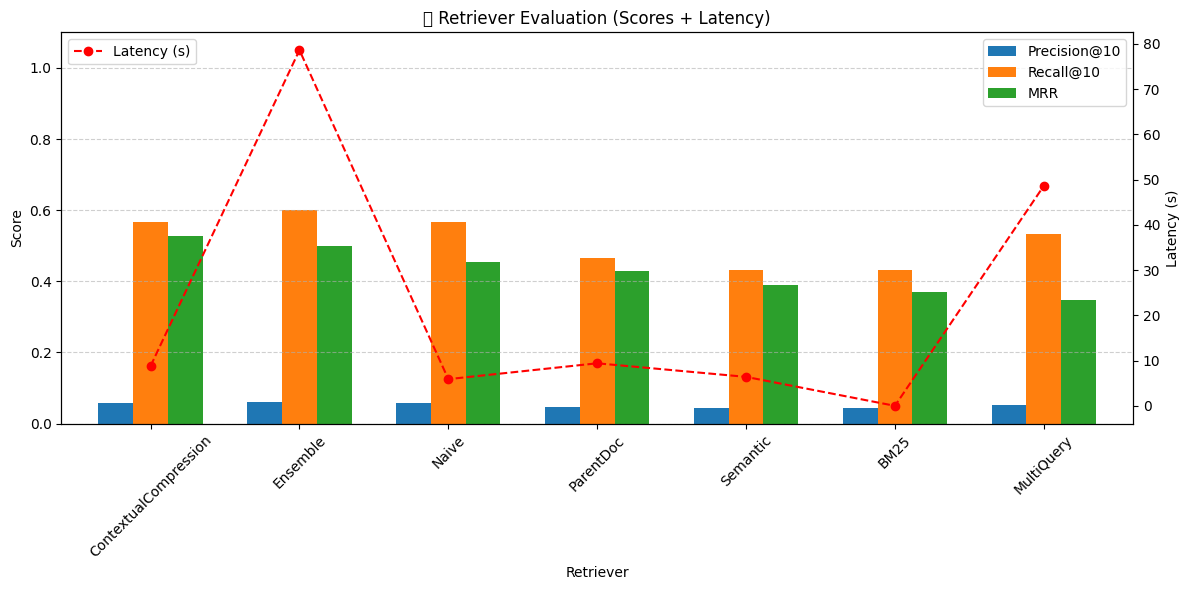

In [77]:
import matplotlib.pyplot as plt

# Set index for plotting
plot_df = results_df.set_index("Retriever")

# Bar chart for score metrics
ax = plot_df[["Precision@10", "Recall@10", "MRR"]].plot.bar(
    figsize=(12, 6),
    rot=45,
    width=0.7
)

# Line plot for latency on a secondary axis
ax2 = ax.twinx()
ax2.plot(
    plot_df["Latency (s)"],
    marker='o',
    linestyle='--',
    color='red',
    label='Latency (s)'
)

# Labels and formatting
ax.set_ylabel("Score")
ax.set_ylim(0, 1.1)
ax.set_title("🔍 Retriever Evaluation (Scores + Latency)")
ax.grid(axis="y", linestyle="--", alpha=0.6)

ax2.set_ylabel("Latency (s)")
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()


In [82]:
from ragas.evaluation import evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy
)
from datasets import Dataset
from tqdm import tqdm
import pandas as pd

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.3)

all_ragas_results = []

for name, retriever in retrievers.items():
    print(f"\n🚀 Running RAGAS eval for: {name}")
    ragas_rows = []

    # 🧪 Sample 30 questions per retriever
    sample_df = golden_df.sample(n=30, random_state=42)

    for _, row in tqdm(sample_df.iterrows(), total=30, desc=name):
        q = str(row["question"]).strip()
        gt = str(row["ground_truth_context"]).strip()

        if not q or not gt:
            continue  # skip empty entries

        try:
            docs = retriever.get_relevant_documents(q)
            contexts = [doc.page_content.strip() for doc in docs[:10] if doc.page_content.strip()]
        except Exception as e:
            print(f"⚠️ Retrieval failed: {e}")
            continue

        if not contexts:
            continue

        prompt = f"""Answer the following question using ONLY the context below:

Context:
{contexts[0]}

Question:
{q}
"""
        try:
            generated = llm.invoke(prompt).content.strip()
        except Exception:
            generated = ""

        if not generated:
            continue

        ragas_rows.append({
            "question": q,
            "answer": generated,
            "contexts": contexts,
            "ground_truths": [gt],
        })

    # ✅ Confirm format is correct
    if len(ragas_rows) == 0:
        print(f"⚠️ Skipping {name} — no valid examples.")
        continue

    df_ragas = pd.DataFrame(ragas_rows)
    ragas_ds = Dataset.from_pandas(df_ragas)

    # ✅ Evaluate all 4 key metrics
    result = evaluate(
        dataset=ragas_ds,
        metrics=[
            context_precision,
            context_recall,
            faithfulness,
            answer_relevancy,
        ]
    )

    all_ragas_results.append({
        "Retriever": name,
        "Context Precision": round(result["context_precision"], 3),
        "Context Recall": round(result["context_recall"], 3),
        "Faithfulness": round(result["faithfulness"], 3),
        "Answer Relevancy": round(result["answer_relevancy"], 3),
    })

# ✅ Display all scores
ragas_full_df = pd.DataFrame(all_ragas_results).sort_values("Answer Relevancy", ascending=False)
display(ragas_full_df)



🚀 Running RAGAS eval for: Naive


Naive: 100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


evaluating with [context_precision]


100%|██████████| 2/2 [01:38<00:00, 49.17s/it]


evaluating with [context_recall]


100%|██████████| 2/2 [00:24<00:00, 12.40s/it]


evaluating with [faithfulness]


100%|██████████| 2/2 [01:00<00:00, 30.05s/it]


evaluating with [answer_relevancy]


100%|██████████| 2/2 [00:28<00:00, 14.45s/it]



🚀 Running RAGAS eval for: BM25


BM25: 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


evaluating with [context_precision]


100%|██████████| 2/2 [00:36<00:00, 18.32s/it]


evaluating with [context_recall]


100%|██████████| 2/2 [00:23<00:00, 11.62s/it]


evaluating with [faithfulness]


100%|██████████| 2/2 [00:49<00:00, 24.66s/it]


evaluating with [answer_relevancy]


100%|██████████| 2/2 [00:30<00:00, 15.27s/it]



🚀 Running RAGAS eval for: MultiQuery


MultiQuery: 100%|██████████| 30/30 [01:00<00:00,  2.01s/it]


evaluating with [context_precision]


100%|██████████| 2/2 [01:39<00:00, 49.77s/it]


evaluating with [context_recall]


100%|██████████| 2/2 [00:26<00:00, 13.45s/it]


evaluating with [faithfulness]


100%|██████████| 2/2 [00:57<00:00, 28.85s/it]


evaluating with [answer_relevancy]


100%|██████████| 2/2 [00:30<00:00, 15.42s/it]



🚀 Running RAGAS eval for: ContextualCompression


ContextualCompression: 100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


evaluating with [context_precision]


100%|██████████| 2/2 [00:32<00:00, 16.14s/it]


evaluating with [context_recall]


100%|██████████| 2/2 [00:23<00:00, 11.94s/it]


evaluating with [faithfulness]


100%|██████████| 2/2 [00:54<00:00, 27.08s/it]


evaluating with [answer_relevancy]


100%|██████████| 2/2 [00:30<00:00, 15.21s/it]



🚀 Running RAGAS eval for: Semantic


Semantic: 100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


evaluating with [context_precision]


100%|██████████| 2/2 [06:42<00:00, 201.35s/it]


evaluating with [context_recall]


100%|██████████| 2/2 [00:24<00:00, 12.19s/it]


evaluating with [faithfulness]


100%|██████████| 2/2 [00:52<00:00, 26.49s/it]


evaluating with [answer_relevancy]


100%|██████████| 2/2 [00:28<00:00, 14.31s/it]



🚀 Running RAGAS eval for: Ensemble


Ensemble: 100%|██████████| 30/30 [01:58<00:00,  3.94s/it]


evaluating with [context_precision]


100%|██████████| 2/2 [01:44<00:00, 52.31s/it]


evaluating with [context_recall]


100%|██████████| 2/2 [00:25<00:00, 12.93s/it]


evaluating with [faithfulness]


100%|██████████| 2/2 [00:56<00:00, 28.48s/it]


evaluating with [answer_relevancy]


100%|██████████| 2/2 [00:28<00:00, 14.10s/it]



🚀 Running RAGAS eval for: ParentDoc


ParentDoc: 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


evaluating with [context_precision]


100%|██████████| 2/2 [00:19<00:00,  9.51s/it]


evaluating with [context_recall]


100%|██████████| 2/2 [00:23<00:00, 11.90s/it]


evaluating with [faithfulness]


100%|██████████| 2/2 [00:56<00:00, 28.42s/it]


evaluating with [answer_relevancy]


100%|██████████| 2/2 [00:31<00:00, 15.91s/it]


,Retriever,Context Precision,Context Recall,Faithfulness,Answer Relevancy
4,Semantic,0.728,0.717,0.861,0.905
6,ParentDoc,0.883,0.822,0.900,0.902
3,ContextualCompression,0.847,0.950,0.871,0.899
5,Ensemble,0.790,0.717,0.870,0.899
0,Naive,0.715,0.767,0.758,0.896
2,MultiQuery,0.711,0.787,0.784,0.891
1,BM25,0.656,0.767,0.772,0.885


In [83]:
from langchain_openai import ChatOpenAI
from langchain.callbacks import get_openai_callback
from tqdm import tqdm
import pandas as pd

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.3)
retriever_costs = []

# Loop over each retriever
for name, retriever in retrievers.items():
    print(f"🧠 Evaluating cost for: {name}")
    total_tokens = 0

    sample_df = golden_df.sample(n=30, random_state=42)  # or whatever number of Qs you used

    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc=name):
        q = row["question"]
        try:
            docs = retriever.get_relevant_documents(q)
            context = docs[0].page_content if docs else ""
        except Exception:
            continue

        prompt = f"""Answer using only the context:\n\nContext:\n{context}\n\nQuestion:\n{q}"""

        with get_openai_callback() as cb:
            try:
                _ = llm.invoke(prompt).content
                total_tokens += cb.total_tokens
            except Exception:
                continue

    cost_usd = round((total_tokens / 1000) * 0.002, 4)  # gpt-3.5-turbo blended rate
    retriever_costs.append({
        "Retriever": name,
        "Tokens Used": total_tokens,
        "Estimated Cost ($)": cost_usd
    })

# Display results
cost_df = pd.DataFrame(retriever_costs).sort_values("Estimated Cost ($)", ascending=False)
display(cost_df)


🧠 Evaluating cost for: Naive


Naive: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


🧠 Evaluating cost for: BM25


BM25: 100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


🧠 Evaluating cost for: MultiQuery


MultiQuery: 100%|██████████| 30/30 [01:47<00:00,  3.59s/it]


🧠 Evaluating cost for: ContextualCompression


ContextualCompression: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


🧠 Evaluating cost for: Semantic


Semantic: 100%|██████████| 30/30 [00:22<00:00,  1.36it/s]


🧠 Evaluating cost for: Ensemble


Ensemble: 100%|██████████| 30/30 [02:07<00:00,  4.25s/it]


🧠 Evaluating cost for: ParentDoc


ParentDoc: 100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


,Retriever,Tokens Used,Estimated Cost ($)
5,Ensemble,7327,0.0147
2,MultiQuery,6770,0.0135
0,Naive,6368,0.0127
3,ContextualCompression,6143,0.0123
6,ParentDoc,6055,0.0121
1,BM25,5653,0.0113
4,Semantic,4513,0.0090


Based on all the metrics in our use case with the Movie Review retrieval we benefit the most from Contextual Compression. 
This provides us the best path in between cost, lag and performance. 
Most importantly since we need to deal with reviews this is extremely valuable that we have high metrics while managing cost + latency. 
Where the quality matters context compression is the top choice for us here.